In [1]:
# import lightgbm as lgb
# from sklearn.base import BaseEstimator, ClassifierMixin

# class LGBMWithLinear(BaseEstimator, ClassifierMixin):
#     def __init__(self, num_leaves=31, learning_rate=0.05):
#         self.num_leaves = num_leaves
#         self.learning_rate = learning_rate
    
#     def fit(self, X, y):
#         self.classes_ = sorted(set(y))
#         lgb_train = lgb.Dataset(X, y)
        
#         params = {
#             'boosting_type': 'gbdt',
#             'objective': 'binary',
#             'metric': 'binary_logloss',
#             'num_leaves': self.num_leaves,
#             'learning_rate': self.learning_rate,
#             'feature_fraction': 0.9,
#             'bagging_fraction': 0.8,
#             'bagging_freq': 5,
#             'verbose': 0,
#             'linear_tree': True,
#         }
        
#         self.gbm = lgb.train(params, lgb_train, num_boost_round=300)
#         return self
    
#     def decision_function(self, X):
#         return self.gbm.predict(X, num_iteration=self.gbm.best_iteration)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from toolz import curry
import sys
sys.path.append("..")
pd.set_option('display.max_columns', 500)

## Processamento da base para cada linha de gêmeos virar duas (uma para cada gêmeo)

In [3]:
df_X = (
    pd.read_csv("twin_pairs_X_3years_samesex.csv")
    .drop(columns=['Unnamed: 0.1', 'Unnamed: 0', "infant_id_0", "infant_id_1"])
)
df_T = (
    pd.read_csv("twin_pairs_T_3years_samesex.csv")
    .drop(columns=['Unnamed: 0'])
)
df_Y = (
    pd.read_csv("twin_pairs_Y_3years_samesex.csv")
    .drop(columns=['Unnamed: 0'])
)

df = pd.concat([df_X, df_T, df_Y], axis=1)

In [4]:
cols_with_index = list(map(lambda col: col.split("_")[0], filter(lambda col: "_0" in col, df.columns)))
cols_without_index = list(filter(lambda col: not any(col.startswith(stub_name) for stub_name in cols_with_index), df.columns))

Basicamente tô dando um filtro em cada um e concatenando.

In [5]:
@curry
def return_i_df(i, cols_with_index, cols_without_index, df):
    df_i = (
        df
        .filter([col+f"_{i}" for col in cols_with_index] + cols_without_index)
        .copy()
        .rename(columns=lambda col: col.replace(f"_{i}", ""))
        .assign(T=i)
    )
    return df_i

return_i = return_i_df(cols_with_index=cols_with_index, cols_without_index=cols_without_index, df=df)

df_final = pd.concat([return_i(i=i) for i in range(2)]).sample(frac=1, replace=False, random_state=42)

___

## Grafo Causal

Grupos das variáveis que definimos.

In [6]:
risk_cols = [
    'alcohol', 'tobacco', 'anemia',
    'diabetes', 'eclamp', 'othermr',
    'cardiac', 'chyper', 'hemo',
    'herpes', 'hydra', 'lung',
    'phyper', 'pre4000', 'preterm',
    'renal', 'rh', 'uterine',
    'incervix'
]

z2_cols = ['dlivord_min', 'dtotord_min']

z3_cols = [
    'birmon', 'adequacy', 'cigar6',
    'drink5', 'gestat10', 'mager8',
    'mpre5', 'nprevistq', 'crace',
    'csex', 'dmar'
]

z4_cols = [
    'bord_0', 'bord_1', 'brstate_reg',
    'data_year', 'stoccfipb_reg'
]

z5_cols = ['birattnd', 'pldel', 'feduc6', 'meduc6']

z6_cols = [
    'brstate', 'dfageq', 'stoccfipb',
    'frace', 'mrace', 'orfath',
    'ormoth', 'mplbir', 'mplbir_reg'
]

all_cols = risk_cols + z2_cols + z3_cols + z4_cols + z5_cols + z6_cols + ["X", "Y"]

In [8]:
from pgmpy.models import BayesianNetwork

model = BayesianNetwork()
model.add_nodes_from(all_cols)
model.add_edges_from(
    [
        ("risk", "X"),
        ("risk", "Y"),
        ("z3", "X"),
        ("z3", "Y"),
        ("z6", "renda"),
        ("renda", "z5"),
        ("renda", "non-observed 1"),
        ("non-observed 1", "X"),
        ("z5", "non-observed 2"),
        ("non-observed 2", "Y"),
        ("z2", "Y"),
    ]
)

Grafo causal:

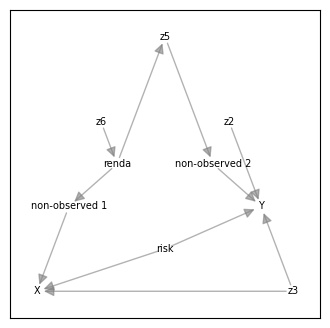

In [9]:
import networkx as nx
# import pylab as plt

plt.figure(figsize=(4, 4))

nx_graph = nx.DiGraph(model.edges())
position_dicts = nx.planar_layout(nx_graph)

nx.draw_networkx_edges(
    nx_graph,
    position_dicts,
    edge_color="gray",
    node_size=100,
    alpha=0.6,
    arrowstyle="-|>",
    arrowsize=15,
)
nx.draw_networkx_labels(nx_graph, position_dicts, font_size=7, font_color="black")
plt.show()

Validando que nosso conjunto satisfaz CB.

In [10]:
from pgmpy.inference import CausalInference

inference = CausalInference(model=model)

proposed_backdoor_set = ["risk", "z3", "z5"]

assert inference.is_valid_backdoor_adjustment_set(
    "X", "Y", proposed_backdoor_set
)

## Estimação

In [11]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

In [12]:
backdoor_set = risk_cols + z3_cols + z5_cols

def return_XZ_y(df, backdoor_set_list):
    return df.filter(["dbirwt"] + backdoor_set_list), np.array(df.mort)

In [13]:
df_train, df_test = train_test_split(
    df_final,
    test_size=0.2,
    random_state=42,
)

XZ_train, y_train = return_XZ_y(df_train, backdoor_set)
XZ_test, y_test = return_XZ_y(df_test, backdoor_set)

Definindo o modelo a partir da fórmula do ajuste.

In [14]:
model = make_pipeline(
    ColumnTransformer(
        [
            (
                "target",
                TargetEncoder(),
                backdoor_set,
            )
        ],
        remainder="passthrough",
    ),
    GridSearchCV(
        estimator=LGBMClassifier(random_state=42),
        cv=KFold(shuffle=True, random_state=42),
        param_grid={"learning_rate": [0.1, 0.05, 0.01]},
        scoring="roc_auc",
    ),
).fit(XZ_train, y_train)

Performance.

In [16]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, model.predict_proba(XZ_test)[:, 1])

0.9265814364079945

Plotando $\mathbb{E}(Y | \textrm{do}(X=x))$ em vermelho e $\mathbb{E}(Y | \textrm{do}(X=x), Z=z)$ em preto. Isso coincide exatamente com o PDP e o ICE.

In [17]:
from sklearn.inspection import partial_dependence

pdp_results = partial_dependence(model, XZ_test, "dbirwt", kind="both", grid_resolution=150, percentiles=(0.01, 0.99))

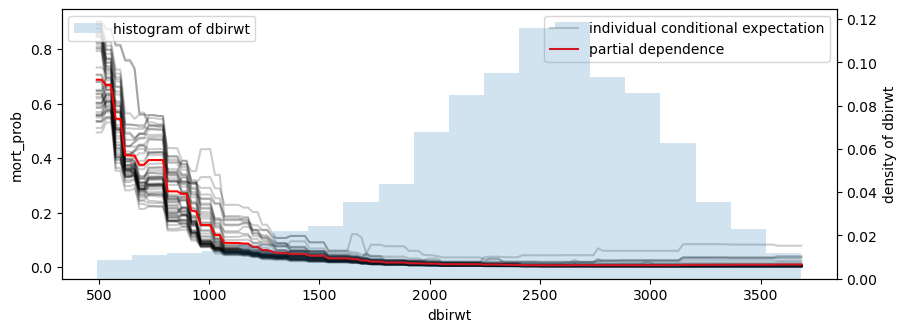

In [18]:
fig, ax = plt.subplots(figsize=(10, 3.5))

min_grid = min(pdp_results["grid_values"][0])
max_grid = max(pdp_results["grid_values"][0])
twinx = ax.twinx()
twinx.hist(XZ_test.dbirwt, bins=np.linspace(min_grid, max_grid, 21), weights=[1/df_test.shape[0]]*df_test.shape[0], alpha=0.2, label="histogram of dbirwt")
twinx.set_ylabel("density of dbirwt")
twinx.legend(loc="upper left")

n_ice_plots = 50
index = np.random.RandomState(42).choice(df_test.shape[0], size=n_ice_plots)
for ind_values, label in zip(pdp_results["individual"][0][index],
                             (n_ice_plots - 1) * ["_nolegend_"] + ["individual conditional expectation"]):
    ax.plot(pdp_results["grid_values"][0], ind_values, "k", alpha=0.2, label=label)

ax.plot(pdp_results["grid_values"][0], pdp_results["average"][0], "r", label="partial dependence")

ax.set_xlabel("dbirwt")
ax.set_ylabel("mort_prob")
ax.legend(loc="upper right")

plt.show()

$x$ que minimiza $\mathbb{E}(Y | \textrm{do}(X=x))$.

In [19]:
pdp_results["grid_values"][0][np.argmin(pdp_results["average"][0])]

2527.080536912752

___